In [20]:
!pip install gshap

In [21]:
import gshap
from gshap.datasets import load_recidivism
from gshap.intergroup import IntergroupDifference

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
tf.random.set_seed(0)

recid = load_recidivism()
X, y = recid.data, recid.target

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def build_mlp(input_dim):
    model = Sequential([
        tf.keras.Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_mlp(X_train.shape[1])
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))

test_score = model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print('Test score: %.4f' % test_score)

Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6093 - loss: 0.6519 - val_accuracy: 0.6680 - val_loss: 0.6032
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6585 - loss: 0.6211 - val_accuracy: 0.6720 - val_loss: 0.5999
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6705 - loss: 0.6158 - val_accuracy: 0.6790 - val_loss: 0.5990
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6585 - loss: 0.6146 - val_accuracy: 0.6740 - val_loss: 0.5979
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6681 - loss: 0.6082 - val_accuracy: 0.6730 - val_loss: 0.5967
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6770 - loss: 0.6079 - val_accuracy: 0.6750 - val_loss: 0.5962
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6740 - loss: 0.6079 - val_accuracy: 0.6780 - val_loss: 0.5972
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6667 - loss: 0.6083 - val_accuracy

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predicted two-year recidivism rate for Whites:  0.45
Predicted two-year recidivism rate for Blacks:  0.57
Relative difference:  0.28


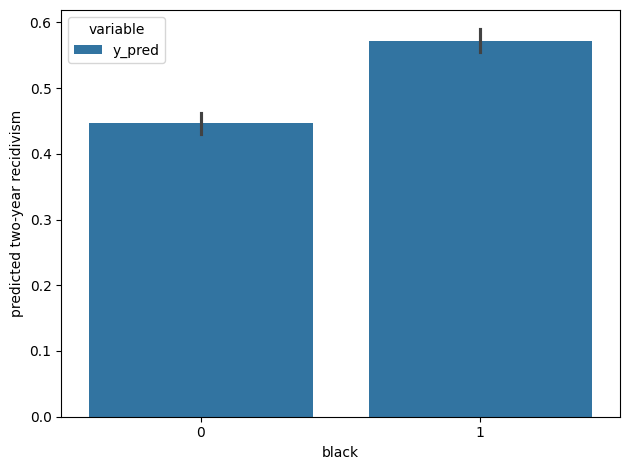

In [23]:
y_pred_test = model.predict(X_test_scaled).flatten()

df = pd.DataFrame(X_test)
df['y_true'] = y_test
df['y_pred'] = y_pred_test

p_non_black, p_black = df.groupby('black')['y_pred'].mean()
print('Predicted two-year recidivism rate for Whites: % .2f' % p_non_black)
print('Predicted two-year recidivism rate for Blacks: % .2f' % p_black)
print('Relative difference: % .2f' % (p_black/p_non_black - 1))

df['id'] = df.index
df_melt = df.melt(id_vars=['id', 'black'], value_vars=['y_pred'])
sns.barplot(y='value', x='black', hue='variable', data=df_melt)
plt.ylabel('predicted two-year recidivism')
plt.tight_layout()
plt.show()


Average predicted recidivism rate per group:
group
BLACK_FEMALE    0.427667
BLACK_MALE      0.604814
WHITE_FEMALE    0.373688
WHITE_MALE      0.464682
Name: y_pred, dtype: float32

Relative difference (BLACK_MALE vs WHITE_MALE): 0.30


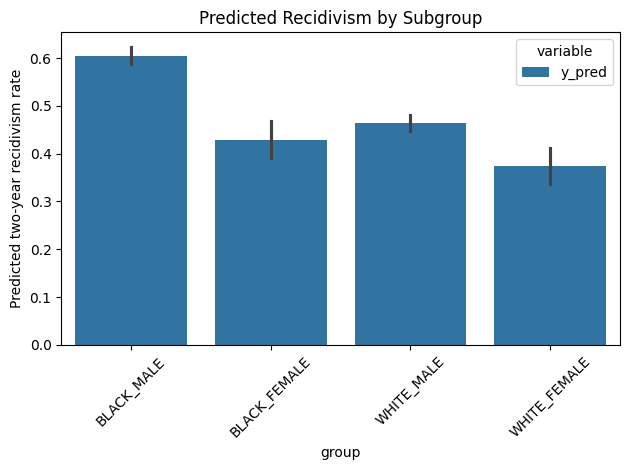

In [24]:
df['group'] = df['black'].map({1: 'BLACK', 0: 'WHITE'}) + "_" + df['male'].map({1: 'MALE', 0: 'FEMALE'})

group_means = df.groupby('group')['y_pred'].mean()
print("\nAverage predicted recidivism rate per group:")
print(group_means)

try:
    p_black_male = group_means['BLACK_MALE']
    p_white_male = group_means['WHITE_MALE']
    print('\nRelative difference (BLACK_MALE vs WHITE_MALE): %.2f' % (p_black_male / p_white_male - 1))
except KeyError:
    print("One of the groups (BLACK_MALE or WHITE_MALE) not found in test set.")

df['id'] = df.index
df_melted = df.melt(id_vars=['id', 'group'], value_vars='y_pred')
sns.barplot(y='value', x='group', hue='variable', data=df_melted)
plt.ylabel('Predicted two-year recidivism rate')
plt.title('Predicted Recidivism by Subgroup')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
df['race'] = df['black'].map({1: 'Black', 0: 'White'})
df['sex'] = df['male'].map({1: 'Male', 0: 'Female'})
df['married'] = df['married'].map({1: 'Married', 0: 'NotMarried'})
df['supervision'] = df['high_supervision'].map({1: 'HighSupervision', 0: 'LowSupervision'})
df['felony'] = df['felony'].map({1: 'Felony', 0: 'Misdemeanor'})
df['priors_bin'] = pd.cut(df['priors_count'], bins=[-1, 0, 3, float('inf')], labels=['NoPrior', 'FewPriors', 'ManyPriors'])

group_cols = ['race', 'sex', 'married', 'felony', 'priors_bin']
df['group'] = df[group_cols].astype(str).agg('_'.join, axis=1)

group_means = df.groupby('group')['y_pred'].mean().sort_values(ascending=False)
print("\nAverage predicted recidivism rate per group:")
print(group_means)

group_a = 'Black_Male_Married_Felony_FewPriors'
group_b = 'White_Female_NotMarried_Misdemeanor_NoPrior'

p_a = group_means.get(group_a)
p_b = group_means.get(group_b)

if p_a and p_b:
    print(f"\n{group_a}: {p_a:.2f}")
    print(f"{group_b}: {p_b:.2f}")
    print(f"Relative difference: {(p_a / p_b - 1):.2f}")
else:
    print("At least one of the selected groups is missing from the test set.")


Average predicted recidivism rate per group:
group
Black_Male_NotMarried_Felony_ManyPriors           0.754886
White_Female_NotMarried_Felony_ManyPriors         0.732575
Black_Male_NotMarried_Misdemeanor_ManyPriors      0.707028
Black_Male_Married_Misdemeanor_ManyPriors         0.681913
White_Male_NotMarried_Felony_ManyPriors           0.668810
Black_Female_NotMarried_Misdemeanor_ManyPriors    0.667544
Black_Female_NotMarried_Felony_ManyPriors         0.643538
White_Female_NotMarried_Misdemeanor_ManyPriors    0.626281
White_Male_NotMarried_Misdemeanor_ManyPriors      0.608387
Black_Male_NotMarried_Felony_FewPriors            0.596151
White_Male_Married_Felony_ManyPriors              0.574129
Black_Male_Married_Felony_ManyPriors              0.549780
Black_Female_NotMarried_Felony_FewPriors          0.511732
Black_Male_NotMarried_Misdemeanor_FewPriors       0.486130
White_Male_NotMarried_Felony_FewPriors            0.475116
Black_Male_NotMarried_Felony_NoPrior              0.459441
Whit

<ipython-input-26-99a681bed01c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='y_pred', y='group', data=group_avg, palette='Blues_d')


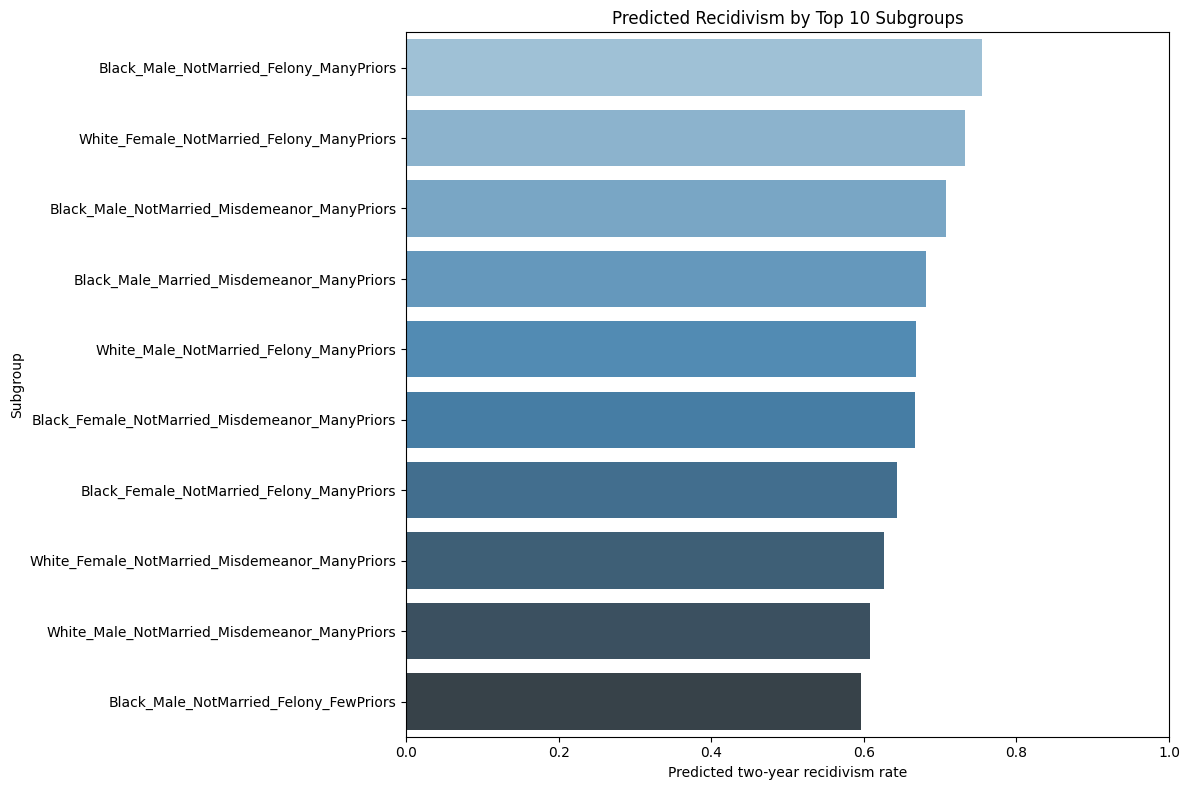

In [26]:
group_avg = df.groupby('group')['y_pred'].mean().reset_index().sort_values('y_pred', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='y_pred', y='group', data=group_avg, palette='Blues_d')


plt.xlabel('Predicted two-year recidivism rate')
plt.ylabel('Subgroup')
plt.title('Predicted Recidivism by Top 10 Subgroups')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

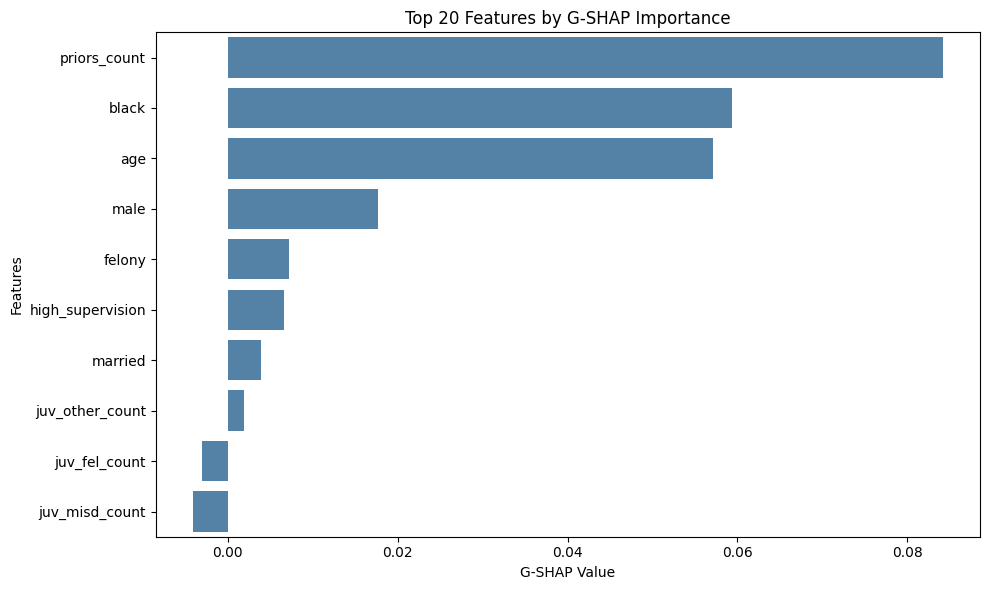

In [27]:
sample_X = X_test_scaled[:100]
sample_group = X_test['black'][:100]
background_X = X_train_scaled[:50]

predict_fn = lambda x: model(x, training=False).numpy().flatten()

g = IntergroupDifference(group=sample_group, distance="relative_mean_distance")
explainer = gshap.KernelExplainer(predict_fn, background_X, g)
gshap_values = explainer.gshap_values(sample_X, nsamples=50)

df_importance = pd.DataFrame({'Features': X.columns, 'G-SHAP': gshap_values})
df_importance = df_importance.sort_values('G-SHAP', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y='Features', x='G-SHAP', data=df_importance.head(20), color='steelblue')
plt.title("Top 20 Features by G-SHAP Importance")
plt.xlabel("G-SHAP Value")
plt.tight_layout()
plt.show()


In [28]:
attack_model = build_mlp(X_train.shape[1])
attack_model.set_weights(model.get_weights())

optimizer = optimizers.Adam(learning_rate=0.001)

def fool_gshap(model, background_X, sample_X, sample_group, epochs=50, batch_size=32):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            preds = model(sample_X, training=True)
            preds = tf.squeeze(preds)

            black_preds = tf.boolean_mask(preds, sample_group == 1)
            white_preds = tf.boolean_mask(preds, sample_group == 0)

            black_mean = tf.reduce_mean(black_preds)
            white_mean = tf.reduce_mean(white_preds)

            loss = tf.abs(black_mean - white_mean)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Fooling Loss (mean diff) = {loss.numpy():.4f}")

print("\nG-SHAP fooling..")
fool_gshap(attack_model, background_X, sample_X, sample_group, epochs=50)
print("G-SHAP fooling completed")



G-SHAP fooling..
Epoch 0: Fooling Loss (mean diff) = 0.1083
Epoch 5: Fooling Loss (mean diff) = 0.0565
Epoch 10: Fooling Loss (mean diff) = 0.0049
Epoch 15: Fooling Loss (mean diff) = 0.0220
Epoch 20: Fooling Loss (mean diff) = 0.0006
Epoch 25: Fooling Loss (mean diff) = 0.0027
Epoch 30: Fooling Loss (mean diff) = 0.0076
Epoch 35: Fooling Loss (mean diff) = 0.0007
Epoch 40: Fooling Loss (mean diff) = 0.0080
Epoch 45: Fooling Loss (mean diff) = 0.0145
G-SHAP fooling completed


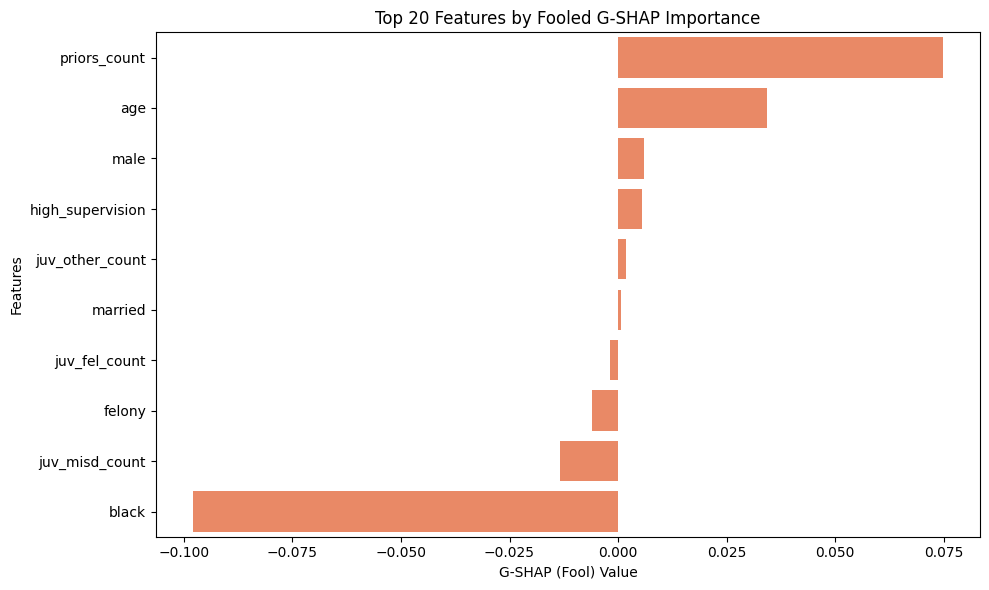

In [29]:
explainer = gshap.KernelExplainer(lambda x: attack_model(x, training=False).numpy().flatten(), background_X, g)
gshap_values_fool = explainer.gshap_values(sample_X, nsamples=50)

df_importance_fool = pd.DataFrame({'Features': X.columns, 'G-SHAP (Fool)': gshap_values_fool})
df_importance_fool = df_importance_fool.sort_values('G-SHAP (Fool)', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y='Features', x='G-SHAP (Fool)', data=df_importance_fool.head(20), color='coral')
plt.title("Top 20 Features by Fooled G-SHAP Importance")
plt.xlabel("G-SHAP (Fool) Value")
plt.tight_layout()
plt.show()


<ipython-input-30-4dd4fc323d14>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="G-SHAP Difference (Fool - Original)", y="Features", data=comparison.head(20), palette="coolwarm")


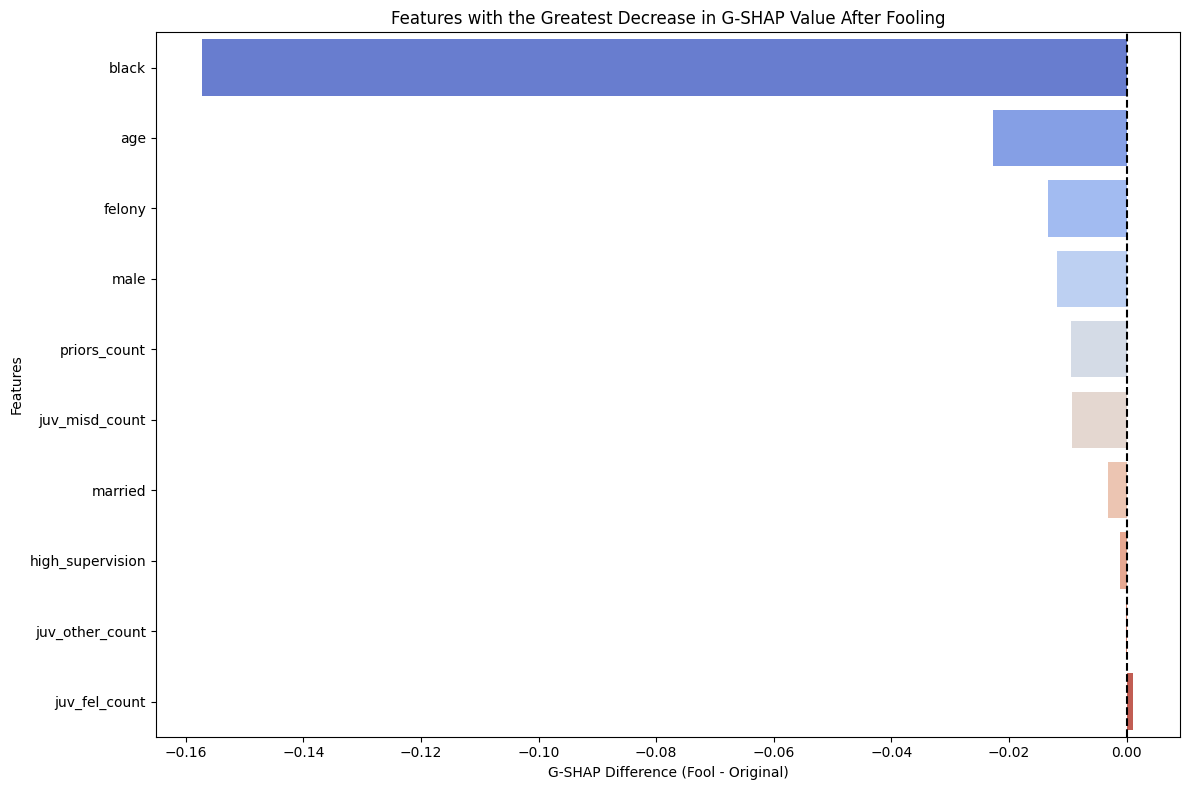

In [30]:
comparison = pd.merge(df_importance, df_importance_fool, on="Features", how="inner")
comparison["G-SHAP Difference (Fool - Original)"] = comparison["G-SHAP (Fool)"] - comparison["G-SHAP"]
comparison = comparison.sort_values("G-SHAP Difference (Fool - Original)")

plt.figure(figsize=(12, 8))
sns.barplot(x="G-SHAP Difference (Fool - Original)", y="Features", data=comparison.head(20), palette="coolwarm")
plt.axvline(0, color='black', linestyle='--')
plt.title("Features with the Greatest Decrease in G-SHAP Value After Fooling")
plt.tight_layout()
plt.show()


In [31]:
mean_gshap_before = df_importance["G-SHAP"].mean()
mean_gshap_after = df_importance_fool["G-SHAP (Fool)"].mean()
mean_diff = mean_gshap_after - mean_gshap_before
percent_change = (mean_diff / abs(mean_gshap_before)) * 100

print(f"Average G-SHAP Change After Fooling: {mean_diff:.6f}")
print(f"Average Percentage Change in G-SHAP After Fooling: %{percent_change:.2f}")

Average G-SHAP Change After Fooling: -0.022689
Average Percentage Change in G-SHAP After Fooling: %-98.25
